# Deep Convolutional Generative Adversarial Network For Audio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import librosa
import librosa.display
import IPython.display as ipd
import math
import os
from tqdm import tqdm

In [3]:
import time

In [4]:
file_path = "../Data/genres_original/hiphop/hiphop.00022.wav"
y, sr = librosa.load(file_path)
print(y.shape)

(661794,)


In [5]:
def load(file_):
    data_, sampling_rate = librosa.load(file_,sr=3000, offset=0.0, duration=30)
    data_ = data_.reshape(1,90001)
    return data_

In [6]:
mfcc_features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
mfcc_features.shape

(40, 1293)

In [7]:
inv_y = librosa.feature.inverse.mfcc_to_audio(mfcc_features)

In [8]:
inv_y

array([0.03245774, 0.04165116, 0.10003405, ..., 0.1036984 , 0.09609834,
       0.0151598 ], dtype=float32)

In [9]:
y

array([-0.1395874 , -0.1746521 , -0.06533813, ...,  0.10778809,
        0.10632324,  0.10507202], dtype=float32)

In [10]:
ipd.Audio(data=y, rate=sr)

In [11]:
ipd.Audio(data=inv_y, rate=sr)

### Audio Style 1

In [137]:
BASE_PATH = '../Data/genres_original/'
CURRENT_PATH = BASE_PATH+"metal/"
df = []
for file in tqdm(os.listdir(CURRENT_PATH)):
    try:
        j = load(CURRENT_PATH+file)
        mfcc_features = librosa.feature.mfcc(y=j[0], sr=3000, n_mfcc=50)
        df.append(mfcc_features)
    except:
        pass

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.77it/s]


### Audio Style 2

In [138]:
CURRENT_PATH = BASE_PATH+"rock/"
for file in tqdm(os.listdir(CURRENT_PATH)):
    try:
        j = load(CURRENT_PATH+file)
        mfcc_features = librosa.feature.mfcc(y=j[0], sr=3000, n_mfcc=50)
        df.append(mfcc_features)
    except:
        pass

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.09it/s]


In [139]:
df = np.array(df)
df.shape

(199, 50, 176)

In [140]:
df = df[:, :, :175]

In [141]:
from sklearn.model_selection import train_test_split

In [142]:
X_train, X_test = train_test_split(df, test_size=0.1, random_state=42, shuffle=True)

In [143]:
X_train.shape

(179, 50, 175)

In [144]:
X_test.shape

(20, 50, 175)

In [145]:
import tensorflow as tf
from tensorflow.keras import layers 

In [146]:
G_loss = []
D_loss = []

In [201]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 2 * 125, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 2, 125)))
#     assert model.output_shape == (None, 7, 4, 125)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(25, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 2, 25)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(5, (5, 5), strides=(5, 5), padding='same', use_bias=False))
    assert model.output_shape == (None, 35, 10, 5)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(5, 5), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 175, 50, 1)

    return model

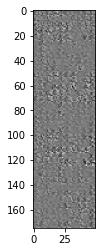

In [202]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [203]:
generated_image.shape

TensorShape([1, 175, 50, 1])

In [204]:
generator.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 1750)              175000    
                                                                 
 batch_normalization_43 (Bat  (None, 1750)             7000      
 chNormalization)                                                
                                                                 
 leaky_re_lu_51 (LeakyReLU)  (None, 1750)              0         
                                                                 
 reshape_18 (Reshape)        (None, 7, 2, 125)         0         
                                                                 
 conv2d_transpose_42 (Conv2D  (None, 7, 2, 25)         78125     
 Transpose)                                                      
                                                                 
 batch_normalization_44 (Bat  (None, 7, 2, 25)       

In [205]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(5, (5, 5), strides=(5, 5), padding='same', input_shape=[175, 50, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(25, (5, 5), strides=(5, 5), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [206]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 35, 10, 5)         130       
                                                                 
 leaky_re_lu_54 (LeakyReLU)  (None, 35, 10, 5)         0         
                                                                 
 dropout_8 (Dropout)         (None, 35, 10, 5)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 2, 25)          3150      
                                                                 
 leaky_re_lu_55 (LeakyReLU)  (None, 7, 2, 25)          0         
                                                                 
 dropout_9 (Dropout)         (None, 7, 2, 25)          0         
                                                                 
 flatten_4 (Flatten)         (None, 350)             

In [207]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00018093]], shape=(1, 1), dtype=float32)


In [208]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [209]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [210]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [211]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [212]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [215]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16

In [216]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [222]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        batch_dim = images.shape[0]
        images = tf.reshape(images, shape=(batch_dim, 175, 50, 1))
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        G_loss.append(gen_loss)
        D_loss.append(disc_loss)
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [223]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
#     display.clear_output(wait=True)
#     generate_and_save_images(generator,
#                            epochs,
#                            seed)

In [224]:
BUFFER_SIZE = 7000
BATCH_SIZE = 32

In [225]:
X_train.shape

(179, 50, 175)

In [226]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [227]:
train(train_dataset, EPOCHS)

Time for epoch 1 is 1.5769662857055664 sec
Time for epoch 2 is 0.10799813270568848 sec
Time for epoch 3 is 0.11200118064880371 sec
Time for epoch 4 is 0.06199836730957031 sec
Time for epoch 5 is 0.05500006675720215 sec
Time for epoch 6 is 0.04900026321411133 sec
Time for epoch 7 is 0.059000492095947266 sec
Time for epoch 8 is 0.05099892616271973 sec
Time for epoch 9 is 0.04700136184692383 sec
Time for epoch 10 is 0.048999786376953125 sec
Time for epoch 11 is 0.04900646209716797 sec
Time for epoch 12 is 0.05699467658996582 sec
Time for epoch 13 is 0.04899787902832031 sec
Time for epoch 14 is 0.0559995174407959 sec
Time for epoch 15 is 0.12100028991699219 sec
Time for epoch 16 is 0.06500029563903809 sec
Time for epoch 17 is 0.050998687744140625 sec
Time for epoch 18 is 0.05100059509277344 sec
Time for epoch 19 is 0.06000113487243652 sec
Time for epoch 20 is 0.06100058555603027 sec
Time for epoch 21 is 0.04700589179992676 sec
Time for epoch 22 is 0.04999971389770508 sec
Time for epoch 23 

Time for epoch 181 is 0.05999946594238281 sec
Time for epoch 182 is 0.06000089645385742 sec
Time for epoch 183 is 0.060001373291015625 sec
Time for epoch 184 is 0.05705380439758301 sec
Time for epoch 185 is 0.05194497108459473 sec
Time for epoch 186 is 0.05100417137145996 sec
Time for epoch 187 is 0.05098438262939453 sec
Time for epoch 188 is 0.04899191856384277 sec
Time for epoch 189 is 0.062001943588256836 sec
Time for epoch 190 is 0.05499720573425293 sec
Time for epoch 191 is 0.049004316329956055 sec
Time for epoch 192 is 0.04699850082397461 sec
Time for epoch 193 is 0.050000905990600586 sec
Time for epoch 194 is 0.049002647399902344 sec
Time for epoch 195 is 0.11801528930664062 sec
Time for epoch 196 is 0.057981252670288086 sec
Time for epoch 197 is 0.05398273468017578 sec
Time for epoch 198 is 0.06299972534179688 sec
Time for epoch 199 is 0.04600119590759277 sec
Time for epoch 200 is 0.05602002143859863 sec
Time for epoch 201 is 0.04799222946166992 sec
Time for epoch 202 is 0.0500

Time for epoch 360 is 0.13099384307861328 sec
Time for epoch 361 is 0.05900239944458008 sec
Time for epoch 362 is 0.05099797248840332 sec
Time for epoch 363 is 0.04700160026550293 sec
Time for epoch 364 is 0.04999971389770508 sec
Time for epoch 365 is 0.05399799346923828 sec
Time for epoch 366 is 0.04900193214416504 sec
Time for epoch 367 is 0.06400036811828613 sec
Time for epoch 368 is 0.05503416061401367 sec
Time for epoch 369 is 0.05496573448181152 sec
Time for epoch 370 is 0.06100130081176758 sec
Time for epoch 371 is 0.055999755859375 sec
Time for epoch 372 is 0.04700326919555664 sec
Time for epoch 373 is 0.05201387405395508 sec
Time for epoch 374 is 0.04901599884033203 sec
Time for epoch 375 is 0.11698412895202637 sec
Time for epoch 376 is 0.055997610092163086 sec
Time for epoch 377 is 0.049021005630493164 sec
Time for epoch 378 is 0.047980546951293945 sec
Time for epoch 379 is 0.04900050163269043 sec
Time for epoch 380 is 0.05001068115234375 sec
Time for epoch 381 is 0.056988477

Testing

In [228]:
seed.shape

TensorShape([16, 100])

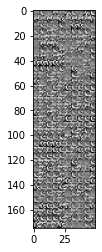

In [229]:
# noise = tf.random.normal([1, 100])
test_generated_image = generator(seed, training=False)
plt.imshow(test_generated_image[0, :, :, 0], cmap='gray')

In [230]:
test_generated_image.shape

TensorShape([16, 175, 50, 1])

In [231]:
generated_mfcc_features = test_generated_image[0].numpy()

In [232]:
generated_mfcc_features = np.reshape(generated_mfcc_features, (175, 50))

In [233]:
generated_mfcc_features.shape

(175, 50)

In [243]:
generated_audio = librosa.feature.inverse.mfcc_to_audio(generated_mfcc_features, n_mels=64)

In [244]:
generated_audio.shape

(25088,)

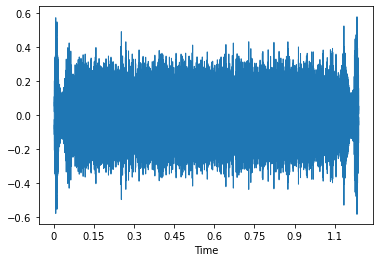

In [245]:
librosa.display.waveshow(generated_audio, sr=sr)

In [246]:
ipd.Audio(data=generated_audio, rate=sr)